In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import Dataset, DataLoader

import scipy.io as sio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_decomposition import PLSCanonical,CCA
from scipy import signal
from scipy.integrate import odeint

from tqdm.auto import tqdm

torch.set_printoptions(precision=10)

%load_ext autoreload
%autoreload 2

torch.set_default_tensor_type(torch.cuda.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


TypeError: type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.

In [ ]:
def lorenz(w,t, sigma, rho, beta):
    
    x,y,z = w[0],w[1],w[2]

    x_dot = sigma*(y - x)
    y_dot = x*(rho-z) - y
    z_dot = x*y - beta*z
    
    w_dot = [x_dot,y_dot,z_dot] 
    

    
    return w_dot



def get_lorenz_jacobian(sol,dt,sigma = 10, rho = 28,beta = 8/3):
    num_steps = sol.shape[0]
    Js = np.zeros((num_steps,3,3))
    I = np.eye(3)
    
    for t in range(num_steps):        
        Js[t,0,:] = [-sigma,sigma,0]
        Js[t,1,:] = [-sol[t,2]+ rho,-1,-sol[t,0]]
        Js[t,2,:] = [sol[t,1],sol[t,0],-beta]
        
        Js[t] = I + dt*Js[t]
        
    return Js



In [ ]:
w0 = [.01,.01,.01]
T = 5e4 # s
dt = .001
K = int(T/dt)
t = np.linspace(0, T, K)
sol = odeint(lorenz, w0, t, args=(10, 28, 8/3))
sol -= sol.mean(0)
sol /= sol.std(0)
#def divide_lorenz_into_training_and_test()

#Js = get_lorenz_jacobian(sol,dt)
#lyaps = lyap_spectrum_QR(Js,T)
#print(lyaps)

In [699]:
def chunk_time_series(series,dt = .001,d2 = 100):
    sol_downsamp = series[::int(1/(10*dt))]
    N = series.shape[-1]
    d1 = int(sol_downsamp.shape[0]/d2)
    sol_chunked = sol_downsamp.reshape((d1,d2,N))
    return sol_chunked

sol_chunked = chunk_time_series(sol)


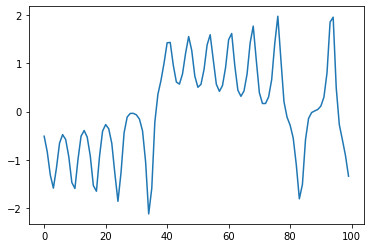

In [702]:
plt.plot(sol_chunked[10,:,0])

In [703]:
class Attractor_Replica_Dataset(torch.utils.data.Dataset):
    'Characterizes a delay-match to sample task'

    def __init__(self, inps,out_des, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.inps = inps
        self.out_des = out_des

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        inp = self.inps[ID]
        y = self.labels[ID].long()
        out = self.out_des[ID]
        
        
        return inp,out,y
    


In [704]:
#inps,out_des,partition,labels = generate_DMTS(dt = dt_ann)
inps = torch.cuda.FloatTensor(sol_chunked.copy())
out_des = torch.cuda.FloatTensor(sol_chunked.copy())
list_IDs = [i for i in range(len(sol_chunked))]
labels = torch.ones(len(sol_chunked))
from sklearn.model_selection import train_test_split
IDs_train, IDs_test = train_test_split(list_IDs, test_size=0.33, random_state=42)


partition = {'train': IDs_train, 'test': IDs_test}

train_params = {'batch_size': 64,
          'shuffle': True,
          'drop_last': True          
         }
test_params = {'batch_size': 64,
          'shuffle': True,
          'drop_last': True          
         }

training_set = Attractor_Replica_Dataset(inps,out_des,partition['train'],labels)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)

test_set = Attractor_Replica_Dataset(inps,out_des,partition['test'],labels)
test_generator = torch.utils.data.DataLoader(test_set, **test_params)

In [705]:
         
        
import torch.jit as jit


'''
Vanilla RNN layer and cells
'''

class vRNNLayer(jit.ScriptModule):
    def __init__(self, cell, *cell_args):
        super(vRNNLayer, self).__init__()
        self.cell = cell(*cell_args)

    @jit.script_method
    def forward(self, input):
        # type: (Tensor) -> Tuple[Tensor, Tensor,Tensor]
        
        state = torch.randn(input.shape[0],self.cell.hidden_size,device = 'cuda')

        #state = input[:,0,:] @ self.cell.weight_ih.T
        
        noise = 0*1.41*.05*torch.randn(input.shape[0],input.shape[1],self.cell.hidden_size,device = 'cuda')
        
        inputs = input.unbind(1)              
        
        outputs = torch.jit.annotate(List[Tensor], [])
        states = torch.jit.annotate(List[Tensor], [])
        for i in range(len(inputs)):
            out, state = self.cell(inputs[i], state, noise[:,i,:])
            outputs += [out]
            states +=[state]

        
        return torch.stack(outputs).permute(1,0,2), torch.stack(states).permute(1,0,2),noise
    
      



class vRNNCell(jit.ScriptModule):
    def __init__(self, input_size, hidden_size,output_size,alpha,g,nonlinearity):
        super(vRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.alpha = alpha 
        self.inv_sqrt_alpha = 1/np.sqrt(alpha)
        self.cont_stab = False
        self.disc_stab = True
        self.g = g
        self.train = 1
        
        self.nonlinearity = nonlinearity
        if nonlinearity == 'tanh':
            self.phi = torch.tanh
        if nonlinearity == 'relu':
            self.phi = F.relu
        
        
    

        
        self.weight_ih = nn.Parameter(torch.FloatTensor(hidden_size, input_size).uniform_(-3,3))
        self.weight_ho = nn.Parameter(torch.normal(0,1/np.sqrt(hidden_size),(output_size, hidden_size)))

        
        self.W_train = nn.Parameter(torch.normal(0,self.g/np.sqrt(hidden_size),(hidden_size, hidden_size)))

        
        
        
        self.bias_oh = nn.Parameter(torch.normal(0,1/np.sqrt(hidden_size),(1,output_size)))
        self.bias_hh = nn.Parameter(torch.normal(0,1/np.sqrt(hidden_size),(1,hidden_size)))
        
        
    @jit.script_method
    def forward(self, inp, state, process_noise):
        # type: (Tensor, Tensor,Tensor) -> Tuple[Tensor, Tensor]
        
        if self.train:       

            fx = -state + self.phi(state @ self.W_train + inp @ self.weight_ih.T + self.bias_hh + self.inv_sqrt_alpha*process_noise)

            hx =  state + self.alpha*(fx)

            hy = hx**2 @ self.weight_ho.T

            return hy, hx  
        
        else:
            with torch.no_grad():
               
                
                fx = -state + self.phi(state @ self.W_train.T + state**2 @ self.weight_ho.T @ self.weight_ih.T + self.bias_hh + self.inv_sqrt_alpha*process_noise)
                hx =  state + self.alpha*(fx)
                hy = hx**2 @ self.weight_ho.T

                return hy, hx  
                
            
            
            
        

In [717]:
input_size = 3
hidden_size = 32
output_size = 3
nl = 'tanh'



max_epochs = 300
peak_every = 1
tau = 1
dt = 1
alpha = dt/tau
g = 1

#rnn = defaultRNN(input_size, hidden_size, output_size,nonlinearity,g = 1.1,train_W_hh = True)
rnn = vRNNLayer(vRNNCell, input_size,hidden_size,output_size,alpha, g, nl)

if torch.cuda.device_count() > 1:       
    model = nn.DataParallel(rnn,device_ids=[1,2])
rnn.to(device)

regs = {'data_similarity': 0,
       'weight_sparsity':0,
        'weight_norm':1e-2,
       'e-i':0,
       'anti-hebbian': 0}



generators = [training_generator,test_generator]

optim_params = list(rnn.parameters())  

optimizer = optim.Adam(optim_params, lr =  0.001, weight_decay = 0)

training_ins = {'optimizer': optimizer,
                   'max_epochs': max_epochs,
                   'regs':regs,
                   'generators': [training_generator,test_generator],
                   'peak_every': peak_every}


In [718]:
    """
    Main training method. 
    
    ARGS:
        -rnn: rnn module to be trained
        -optimizer: optimizer to use for training
        -max_epochs: number of epochs to use during training
        -regs: regularization hyperparameters
        -generators: training and testing generators
        -peak_every: 'peak every peak_every epochs'
        -avg_response: condtion averaged neural data, for similarity comparisons
        -dt: time step used in defining RNN and task
    
    
    RETURNS:
        -training_loss_mean: mean training loss (one value per epoch)
        -frac_corrects: fraction of correct trials, computed over test samples, 1 per peak_every
        -lyaps_during_training: largest lyapunov exponents during training, computed over test samples, 1 per peak_every
        -avg_slopes_during_training: average networks slope during training, computed over test samples, 1 per peak_every. Average computed across batches, time and units.
        -similarities_during_training: similarity between rnn and neural data, 1 per peak_every
        -out_hidden: one example of hidden_activations, for sanity checks
        -out_readout: one example of network readout, for sanity checks
        -y: one example of labels, for sanity checks
        -out_des: one example of desired output, for sanity checks
        -W_norm:   2-norm of recurrent weight matrix during training
    """
    
    optimizer = training_ins['optimizer']

    
    
    training_generator,test_generator = training_ins['generators'][0], training_ins['generators'][1]
    
    L2Loss = nn.L1Loss()
    num_snapshots = int(max_epochs/peak_every) + 1


    training_loss_mean =torch.zeros(max_epochs)

    
    pbar = range(max_epochs)
        
    


    count_peaks = -1
    
    
    for epoch in tqdm(pbar):
        
        '''

        if epoch%peak_every == 0 or epoch == max_epochs-1:  
            count_peaks += 1
            
            rnn.train(False)
            with torch.no_grad():  
                count+= 1
        '''
                

        
       
        rnn.train == 1

        training_loss = torch.zeros(max_epochs)
        count_train = -1
        rnn.cell.train = 1

        for inp, out_des,y in training_generator:    
            count_train += 1


            optimizer.zero_grad()        

            out_readout, out_hidden,_ = rnn(inp)

            #loss_L2_weights = regs['weight_norm']*rnn.rnn.W.norm(p = 1)
            #loss_mu_1 = regs['weight_norm']*get_mu_1_loss(rnn.cell.W)
            loss_L1_weights = rnn.cell.W_train.norm(p = 1)

            
            loss = L2Loss(out_readout,out_des) + 1e-5*loss_L1_weights
            
            
            loss.backward()
            optimizer.step()
            training_loss[count_train] = loss.item()



        training_loss_mean[epoch] = training_loss.mean()



    

        

    

    
    
    
    

  0%|          | 0/300 [00:00<?, ?it/s]

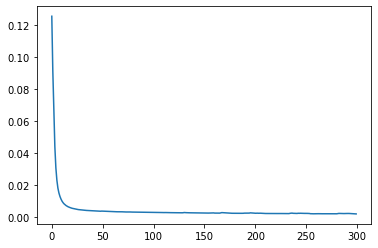

In [719]:
plt.plot(training_loss_mean.cpu().detach())

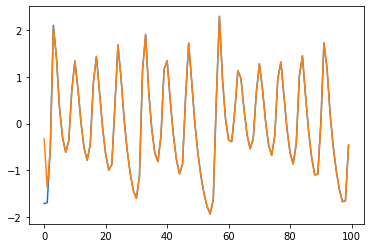

In [720]:
ind = 60
plt.plot(inp[ind,:,2].cpu().detach())
plt.plot(out_readout[ind,:,2].cpu().detach())

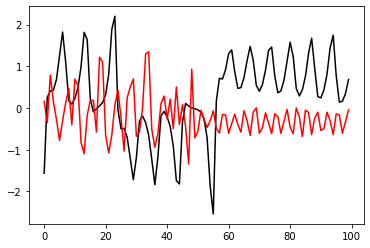

In [728]:
inp, out_des,y =  next(iter(test_generator))

rnn.cell.train = 0 
out_readout, out_hidden,_ = rnn(inp)

ind = 60
plt.plot(inp[ind,:,1].cpu().detach(),'k')
plt.plot(out_readout[ind,:,1].cpu().detach().T,'r');

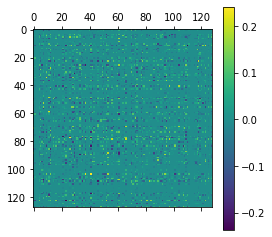

In [578]:
plt.matshow(rnn.cell.W_train.cpu().detach())
plt.colorbar()